# <center> Kernel-Based Changepoint Detection </center>

## 1 Introduction
In this lab we'll examine one method for performing changepoint detection on a signal (in this case, features from songs). The intuition is that we're roughly going to find a time point $t$ where the mean of the features before $t$ is as far as possible from the mean of the features after $t$. This $t$ is then our estimate of where the song changes the most.

Sources:
- Some of the data used to prepare this lab comes from the Million Song Dataset https://labrosa.ee.columbia.edu/millionsong/
- Some of the code used to initially process the data is from https://github.com/tbertinmahieux/MSongsDB
- The algorithm described is based on the algorithm used in the following paper:  
Harchaoui, Z., Moulines, E., & Bach, F. R. (2009). Kernel change-point analysis. In Advances in Neural Information Processing Systems (pp. 609-616).

## 2 Kernel-based changepoint algorithm
We're going to try to locate one changepoint in a song. The idea behind the algorithm is that the features of the song before the changepoint are going to be similar, and the features after the changepoint are going to be similar. Hence, we will look for the time $t$ at which the standardized distance (defined below) from the mean of the features before time $t$ to the mean of the features after time $t$ is maximized.

However, we are going to do this with kernels. Recall that as long as a kernel is positive semi-definite, we can write the kernel as an inner product:
$$k(x,x') = \langle\phi(x), \phi(x')\rangle_\mathcal{H}$$
for some function $\phi$. If we specify a kernel $k$, we (possibly implicitly) use $\phi(x_1), \phi(x_2), \dots, \phi(x_T)$ as our new features instead of $x_1, x_2, \dots, x_T$.

Consider the following setup: The song is described by a sequence of features $x_1, x_2, \dots, x_T\in\mathbf{X}$. Let $k:\mathbf{X}\times\mathbf{X}\to\mathbb{R}$ be a kernel function between the features and $\phi:\mathbf{X}\to\mathcal{H}$ be the associated feature map. 

We are going to solve the following problem:
$$ \text{argmax}_{t\in \{1,...,T-1\}} \frac{t(T-t)}{T} \|\hat\mu_1-\hat\mu_2\|^2_\mathcal{H},$$
where $\hat\mu_1=\frac{1}{t} \sum_{i=1}^{t} \phi(x_i)$ and $\hat\mu_2=\frac{1}{T-t} \sum_{i=t+1}^{T} \phi(x_i)$. The value $t$ that maximizes the above expression will be correspond to the last index in our estimated first part of the song. 

What if we don't know $\phi$, but just know $k$? Or what if we know $\phi$, but it's infinite-dimensional? It turns out that this is not an issue because we can rewrite the objective function using only $k$, as noted in Exercise 1.

** Exercise 1* ** Using the fact that $k(x_i, x_j) = \langle \phi(x_i), \phi(x_j)\rangle_\mathcal{H}$, show that the problem may be rewritten as 
 $$ \text{argmax}_{t\in \{1,...,T-1\}} \left\{\frac{T-t}{tT} \sum_{i=1}^t\sum_{j=1}^t k(x_i, x_j) -\frac{2}{T} \sum_{i=1}^t\sum_{j=t+1}^T k(x_i, x_j) + \frac{t}{(T-t)T} \sum_{i=t+1}^T\sum_{j=t+1}^T k(x_i, x_j)\right\}.$$

The code you will complete below takes in either a matrix of $\phi(x_1),\dots, \phi(x_T)$ (in the case of `estimate_cp_phi`) or the gram matrix $K$ (in the case of `estimate_cp_k`) and estimates the location of the changepoint.

** Exercise 2 ** In this exercise you will fill in the code in the function `estimate_cp_phi` to compute $$ \text{argmax}_{t\in \{1,...,T-1\}} \frac{t(T-t)}{T} \|\hat\mu_1-\hat\mu_2\|^2_\mathcal{H}.$$
Fill in code that computes:
1. The mean of the observations from $0$ to $t-1$ 
2. The mean of the observations from $t$ to $T$ 
3. The value of the statistic $\frac{t(T-t)}{T} \|\hat\mu_1-\hat\mu_2\|^2_\mathcal{H}$
3. The argmax of the above statistic

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

def estimate_cp_phi(phis, plot_objective=False):
    """
    Given the feature maps phis, where each row is one observation i.e., each row represents one phi(x_i), 
    we will estimate the location of one changepoint. 
    :param phis: Matrix of phi(x_1),..., phi(x_T)
    :param plot_objective: Whether to plot the objective values
    :return t_opt: Estimated changepoint index. This is the last index in the first part of the song.
    """
    T = np.size(phis, 0)
    obj_vals = np.zeros(T-1)
    for t in range(1, T):
        mean1 = np.mean(phis[:t, :], axis=0)  # Fill in the mean of the observations from 0 to t-1 (inclusive)
        mean2 = np.mean(phis[t:, :], axis=0)  # Fill in the mean of the observations from t to T-1 (inclusive)
        obj_vals[t-1] = t*(T-t)/T*np.linalg.norm(mean1-mean2, ord=2)**2  # Fill in the value of the statistic here
    t_opt = np.argmax(obj_vals)  # Fill in the maximizer of the above statistic
    t_opt += 1   # (Convert to 1-based indexing)
    if plot_objective:
        plot_obj(obj_vals)
    return t_opt

** Exercise 3 ** In this exercise you will fill in the code in the function `estimate_cp_k` to compute $$ \text{argmax}_{t\in \{1,...,T-1\}} \left\{\frac{T-t}{tT} \sum_{i=1}^t\sum_{j=1}^t k(x_i, x_j) -\frac{2}{T} \sum_{i=1}^t\sum_{j=t+1}^T k(x_i, x_j) + \frac{t}{(T-t)T} \sum_{i=t+1}^T\sum_{j=t+1}^T k(x_i, x_j)\right\}.$$
Fill in code that computes:
1. The first term in brackets
2. The second term in brackets
3. The third term in brackets
3. The argmax of the statistic $\frac{T-t}{tT} \sum_{i=1}^t\sum_{j=1}^t k(x_i, x_j) -\frac{2}{T} \sum_{i=1}^t\sum_{j=t+1}^T k(x_i, x_j) + \frac{t}{(T-t)T} \sum_{i=t+1}^T\sum_{j=t+1}^T k(x_i, x_j)$

In [2]:
def estimate_cp_k(gram_matrix, plot_objective=False):
    """
    Given the gram matrix gram_matrix which contains the evaluations of the kernel k on the data, we
    we will estimate the location of one changepoint. 
    :param gram_matrix: Gram matrix (matrix of kernel evaluations)
    :param plot_objective: Whether to plot the objective values
    :return t_opt: Estimated changepoint index. This is the last index in the first part of the song.
    """
    T = np.size(gram_matrix, 0)
    obj_vals = np.zeros(T-1)
    for t in range(1, T):
        term1 = (T-t)/(t*T)*np.sum(gram_matrix[0:t, 0:t])  # Fill in the first term here
        term2 = -2/T*np.sum(gram_matrix[0:t, t:T])  # Fill in the second term here
        term3 = t/((T-t)*T)*np.sum(gram_matrix[t:T, t:T])  # Fill in the third term here
        obj_vals[t-1] = term1 + term2 + term3
    t_opt = np.argmax(obj_vals)  # Fill in the maximizer of the above statistic
    t_opt +=1
    if plot_objective:
        plot_obj(obj_vals)
    return t_opt

In [3]:
def plot_obj(obj_vals):
    """
    Plot the objective values computed in one of the changepoint detection functions above.
    :param obj_vals: The computed objective values at each changepoint index
    """
    plt.plot(obj_vals)
    plt.xlabel('Interval index')
    plt.ylabel('Objective value')
    plt.show()

## 3 Feature Generation 

The Million Song Dataset consists of (surprise!) features from one million songs. You can see an example track description here:
https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description  
I used songs from the million song subset in step 2, part A below.

### 3.1 Feature generation steps
We don't have time to go through the code related to feature generation, but the steps are as follows:
1. Extract the values for the various pitches, timbre, and loudness in each segment of each song.
2. Create bag-of-words features:
  1. Take a subset of the songs that you are not going to test on (I took 1000 songs) and do the following:
    - Stack the features from each segment of each song into one very long matrix. The number of columns will be the number of features in each segment.
    - Center and scale the features.
    - Run PCA and transform the features. The number of principal components I used is the number that explained 95% of the variance.
    - Run K-means on the data and store the cluster centers. I used 1024 clusters.
  2. On each song you are going to test on, do the following:
    - Stack all of the features from each segment of the song.
    - Center and scale the features *using the mean and standard deviation from the previous set of songs*.
    - Transform the features using the principal components from the previous set of songs.
    - Mirror the features from the first and last 2.5 seconds of the song, so that the song is effectively 5s longer. This allows us to capture more of what happens at the very beginning and very end of the song.
    - Create a matrix of zeros of dimension # 5s intervals x # cluster centers.
    - For each segment in each consecutive 5s window (with an overlap of 20%), find the closest cluster center and add 1 to the element of the above matrix corresponding to this interval and that cluster center.
    - Normalize the histograms you just created so they sum to 1. These histograms are your features for each 5s interval of your song.

## 4 Examples
In our examples we'll use the Hellinger kernel. Recall that the Hellinger kernel, which is used for histograms, is given by
$$ k(h,h') = \sum_{i=1}^d \sqrt{h_ih_i'}, \hspace{0.5cm} h = 
\begin{bmatrix}
h_1\\
h_2\\
\vdots \\
h_d
\end{bmatrix}, \hspace{0.2cm} h' = 
\begin{bmatrix}
h'_1\\
h'_2\\
\vdots \\
h'_d
\end{bmatrix}$$
where $h$ and $h'$ are normalized histograms.
Also note that we can write
$$ k(h,h') = \langle \sqrt{h}, \sqrt{h'} \rangle,$$
where the square root is applied element-wise. Hence, here we have that $\phi(h) = \sqrt{h}$.

In [5]:
import os

def cut_song(features, time_interval, window_length, window_overlap):
    """
    Cut the features of song to the features in a specified time interval. If a window overlaps with either end,
    it includes that entire window. Hence, the time interal you cut it to will likely be slightly larger than
    what you specified.
    :param features: The features of the entire song
    :param time_interval: A tuple of length 2 indicating the start and end time to cut it to. 
    :param window_length: Window length used when creating the features
    :param window_overlap: Amount of overlap across windows when creating the features
    :return features[cp_start_interval:cp_end_interval]: The features in the specified window (+ slightly more)
    :return cp_start_interval+1: Largest index of an interval beginning at or before time_interval[0] (indexing
                                 starting at 1)
    """
    nint = np.size(features, 0)
    interval_starting_points = np.array([-window_length/2 + window_length*(1-window_overlap)*i for i in range(0, nint)])
    cp_start_interval = np.max(np.where(interval_starting_points <= time_interval[0]))
    cp_end_interval = np.min(np.where(interval_starting_points >= time_interval[1]))
    return features[cp_start_interval:cp_end_interval], cp_start_interval+1

** Exercise 4 ** Recall from above that we wrote functions that can perform changepoint detection in two different but equivalent ways: One using the feature map $\phi$ and one using the kernel $k$. Fill in the code below to compute the inputs to these functions: A matrix containing $\phi(x_i)$ for all $i$ and the gram matrix (the matrix of kernel evaluations on each pair of data points). Use the Hellinger kernel described above.

In [8]:
def main(song_title, time_interval, bow_features_path, window_length, window_overlap):
    """
    Load the features from the specified song, call the algorithm to estimate the changepoint, and report
    the time of the estimated changepoint.
    :param song_title: Title of song to estimate the changepoint for (This must be the same as the file name)
    :param time_interval: Time interval of the song in which to search for a changepoint
    :param bow_features_path: File path to the location of the bag-of-words features that were precomputed
    :param window_length: Sliding window length used when creating the features
    :param window_overlap: Amount of overlap across windows when creating the features
    """
    print('Estimating the location of a changepoint in the song "' + song_title + '"...')
    features = np.load(os.path.join(bow_features_path, song_title + '.npy'))
    features, cp_start = cut_song(features, time_interval, window_length, window_overlap)
    # Method 1- Using the objective function with phis
    phis = np.sqrt(features)  # Compute phi applied to the features (using phi for the Hellinger kernel)
    est_cp = estimate_cp_phi(phis, plot_objective=True)
    # Method 2- Using the objective function with K
    gram_matrix = np.sqrt(features).dot(np.sqrt(features.T))  # Compute the gram matrix
    est_cp2 = estimate_cp_k(gram_matrix, plot_objective=True)
    # The middle of each interval is given by 
    # window_length*(1-window_overlap)*(t-1)
    # for each t=1,...,T since the center of the first interval is at 0.
    # We want to return the middle of the overlapping part between the end time of the last interval in the 
    # first portion of the song and the first interval in the second portion of the song. To do this, we need
    # to add window_length*(1-window_overlap)/2 (=2 if the window length=5 and overlap=0.2) to the above 
    # expression. If we cut the song, then we need to take that into account as well.
    start_time = window_length*(1-window_overlap)*(cp_start-1)
    est_cp_time1 = start_time + window_length*(1-window_overlap)*(est_cp-1)+window_length*(1-window_overlap)/2
    print('Estimated changepoint using method 1:', est_cp_time1, 's')
    est_cp_time2 = start_time + window_length*(1-window_overlap)*(est_cp2-1)+window_length*(1-window_overlap)/2
    print('Estimated changepoint using method 2 (which is equivalent):', est_cp_time2, 's')

Let's try it! I chose two songs (and two intervals) in which to search for a changepoint:
- Hakuna Matata https://www.youtube.com/watch?v=ITDD4doC6iw 
- Le Même Sang https://www.youtube.com/watch?v=wR0dlt8JRjk

The features for the songs are generated from 5s intervals, with 1s of overlap. Hence, the best we can hope for is to be within about 2s of a true changepoint. We can try it with several songs:

Estimating the location of a changepoint in the song "le_meme_sang"...


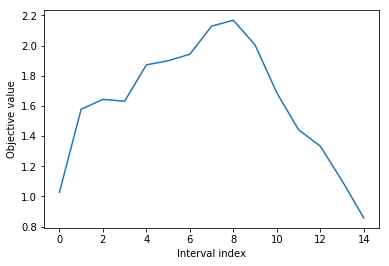

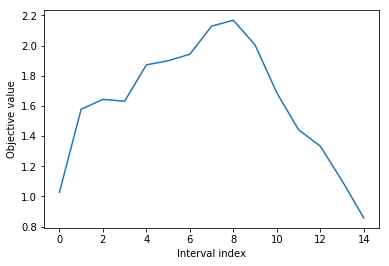

Estimated changepoint using method 1: 34.0 s
Estimated changepoint using method 2 (which is equivalent): 34.0 s


In [10]:
# song_title = 'hakuna_matata'
# time_interval = (60, 100)
song_title = 'le_meme_sang'
time_interval = (0, 60)
bow_features_path = os.path.join('data', 'bow_features', '0_1000_0.95_1024_5_0.2_0') 
window_length = 5
window_overlap = 0.2
main(song_title, time_interval, bow_features_path, window_length, window_overlap)